# Baseline model for adult data

In this notebook we train a simple model on the adult data that can serve as a counterfactual for what would have happened if we hadn't made any kind of fairness intervention.

In [1]:
from pathlib import Path
import numpy as np

import pandas as pd
from fairlearn.metrics import (
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference,
    equalized_odds_ratio,
)

from helpers.utils import plot_fairness_and_accuracy 
import torch
from torch.utils.data import DataLoader
import torch.nn as nn


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
import umap


In [5]:
import random
random.seed(3)

Load the preprocessed data. Check out the preprocessing notebook for details on how this data was obtained.

In [6]:
artifacts_dir = Path("artifacts")
data_dir = artifacts_dir / "data" / "adult"

train = pd.read_csv(data_dir / "processed" / "train.csv")
val = pd.read_csv(data_dir / "processed" / "val.csv")
test = pd.read_csv(data_dir / "processed" / "test.csv")

train_oh = pd.read_csv(data_dir / "processed" / "train-one-hot.csv")
val_oh = pd.read_csv(data_dir / "processed" / "val-one-hot.csv")
test_oh = pd.read_csv(data_dir / "processed" / "test-one-hot.csv")

In [7]:
train_oh.head()

,age,sex,capital_gain,capital_loss,hours_per_week,salary,workclass_federal_gov,workclass_local_gov,workclass_private,workclass_self_emp_inc,...,marital_status_divorced,marital_status_married_af_spouse,marital_status_married_civ_spouse,marital_status_married_spouse_absent,marital_status_never_married,marital_status_separated,marital_status_widowed,native_country_mexico,native_country_other,native_country_united_states
0,1.108936,1,-0.147741,-0.218133,2.416833,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.805386,1,-0.147741,-0.218133,2.416833,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,-0.788255,1,-0.147741,-0.218133,-0.079269,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3,1.640150,0,-0.147741,-0.218133,-0.079269,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
4,1.108936,1,-0.147741,-0.218133,-0.079269,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


In [8]:
train_oh.columns

Index(['age', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
       'salary', 'workclass_federal_gov', 'workclass_local_gov',
       'workclass_private', 'workclass_self_emp_inc',
       'workclass_self_emp_not_inc', 'workclass_state_gov',
       'workclass_without_pay', 'education_10th', 'education_11th',
       'education_12th', 'education_1st_4th', 'education_5th_6th',
       'education_7th_8th', 'education_9th', 'education_assoc_acdm',
       'education_assoc_voc', 'education_bachelors', 'education_doctorate',
       'education_hs_grad', 'education_masters', 'education_preschool',
       'education_prof_school', 'education_some_college',
       'occupation_adm_clerical', 'occupation_armed_forces',
       'occupation_craft_repair', 'occupation_exec_managerial',
       'occupation_farming_fishing', 'occupation_handlers_cleaners',
       'occupation_machine_op_inspct', 'occupation_other_service',
       'occupation_priv_house_serv', 'occupation_prof_specialty',
       'occup

## Load data

In [9]:
class AdultDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.X = torch.tensor(df.drop(columns=["salary"]).values, dtype=torch.float32)
        self.y = torch.tensor(df["salary"].values, dtype=torch.float32)
        self.s = torch.tensor(df["sex"].values, dtype=torch.int64)  # sensitive attr
        
        race_columns = [col for col in df.columns if col.startswith("race_")]
        race_one_hot = df[race_columns].values
        self.s2 = torch.tensor(np.argmax(race_one_hot, axis=1), dtype=torch.int64)  # categorical race class


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.s[idx], self.s2[idx]

In [10]:
train_ds = AdultDataset(train_oh)
val_ds = AdultDataset(val_oh)
test_ds = AdultDataset(test_oh)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)

## Training a model to predict salary

In [11]:
class FairMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, 100)
        self.l2 = nn.Linear(100, 100)
        self.l3 = nn.Linear(100, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h1 = self.relu(self.l1(x))
        h2 = self.relu(self.l2(h1))
        out = self.sigmoid(self.l3(h2))
        return out.squeeze()

    def get_hidden(self, x):
        """Returns all hidden representations"""
        h1 = self.relu(self.l1(x))
        h2 = self.relu(self.l2(h1))
        return h1, h2

In [12]:
def demographic_parity_loss(y_hat, s):
    group_0 = y_hat[s == 0]
    group_1 = y_hat[s == 1]
    if len(group_0) == 0 or len(group_1) == 0:
        return torch.tensor(0.0, device=y_hat.device)
    return (group_0.mean() - group_1.mean())**2

## Penalizing the loss in regard to the sex

In [13]:
model = FairMLP(input_dim=train_oh.shape[1] - 1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
bce_loss = nn.BCELoss()

lambda_logspace = [round(l, 3) for l in np.logspace(-2, 2, 12).tolist()]
lambda_manual = [0.0, 0.8, 1.0, 1.2, 2.0]

lambda_combined = sorted(set(lambda_logspace + lambda_manual))
results = {
    "lambda": [],
    "test_accuracy": [],
    "dp_diff_sex": [],
    "dp_ratio_sex": [],
    "eo_diff_sex": [],
    "eo_ratio_sex": [],
    "hidden_1": [],
    "hidden_2": [],
    "output": [],
}


for lambda_dp in lambda_combined:
    print(f"\nTraining (DP penalty on SEX only), λ = {lambda_dp}")
    

    # Training loop
    for epoch in range(10):
        model.train()
        for x, y, s, _ in train_loader:  # ignore s2
            optimizer.zero_grad()
            y_hat = model(x)
            loss_base = bce_loss(y_hat, y)
            loss_dp = demographic_parity_loss(y_hat, s)  # penalize gender
            loss = loss_base + lambda_dp * loss_dp
            loss.backward()
            optimizer.step()
            

    # Evaluation
    model.eval()
    X_test = torch.tensor(test_oh.drop(columns=["salary"]).values, dtype=torch.float32)
    y_test = test_oh["salary"].values
    s_sex = test_oh["sex"].values

    with torch.no_grad():
        h1, h2 = model.get_hidden(X_test)
        h3 = model(X_test).unsqueeze(1)

    test_pred = (h3.numpy() > 0.5).astype(int)

    # Train-test split for probe
    train_idx, val_idx = train_test_split(np.arange(len(s_sex)), test_size=0.3, stratify=s_sex, random_state=42)
    h1_train, h1_val = h1[train_idx], h1[val_idx]
    h2_train, h2_val = h2[train_idx], h2[val_idx]
    y_train, y_val = s_sex[train_idx], s_sex[val_idx]

    probe_l1 = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, class_weight='balanced').fit(h1_train, y_train)
    probe_l2 = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, class_weight='balanced').fit(h2_train, y_train)
    
    probe_l1_acc = accuracy_score(y_val, probe_l1.predict(h1_val))  # L1 probe tested on L1
    probe_l2_acc = accuracy_score(y_val, probe_l2.predict(h2_val))  # L2 probe tested on L2


    l1_to_l2 = accuracy_score(y_val, probe_l1.predict(h2_val))
    l2_to_l1 = accuracy_score(y_val, probe_l2.predict(h1_val))

    results.setdefault("probe_l1_to_l2", []).append(l1_to_l2)
    results.setdefault("probe_l2_to_l1", []).append(l2_to_l1)
    results.setdefault("probe_l1_acc", []).append(probe_l1_acc)
    results.setdefault("probe_l2_acc", []).append(probe_l2_acc)


    # Fairness metrics
    dpd_sex = demographic_parity_difference(y_test, test_pred, sensitive_features=s_sex)
    dpr_sex = demographic_parity_ratio(y_test, test_pred, sensitive_features=s_sex)

    eod_sex = equalized_odds_difference(y_test, test_pred, sensitive_features=s_sex)
    eor_sex = equalized_odds_ratio(y_test, test_pred, sensitive_features=s_sex)

    results["lambda"].append(lambda_dp)
    results["test_accuracy"].append(accuracy_score(y_test, test_pred))
    results["dp_diff_sex"].append(dpd_sex)
    results["dp_ratio_sex"].append(dpr_sex)
    results["eo_diff_sex"].append(eod_sex)
    results["eo_ratio_sex"].append(eor_sex)
    results["hidden_1"].append(h1.numpy())
    results["hidden_2"].append(h2.numpy())
    results["output"].append(h3.numpy())


Training (DP penalty on SEX only), λ = 0.0

Training (DP penalty on SEX only), λ = 0.01

Training (DP penalty on SEX only), λ = 0.023

Training (DP penalty on SEX only), λ = 0.053

Training (DP penalty on SEX only), λ = 0.123

Training (DP penalty on SEX only), λ = 0.285

Training (DP penalty on SEX only), λ = 0.658

Training (DP penalty on SEX only), λ = 0.8

Training (DP penalty on SEX only), λ = 1.0

Training (DP penalty on SEX only), λ = 1.2

Training (DP penalty on SEX only), λ = 1.52

Training (DP penalty on SEX only), λ = 2.0

Training (DP penalty on SEX only), λ = 3.511

Training (DP penalty on SEX only), λ = 8.111

Training (DP penalty on SEX only), λ = 18.738

Training (DP penalty on SEX only), λ = 43.288

Training (DP penalty on SEX only), λ = 100.0


In [37]:
def plot_fairness_and_accuracy(results, group="sex", title="Accuracy and Fairness vs λ"):
    sns.set(style="whitegrid", font_scale=1.2)
    color1= "#fca483"
    color2 = "#71c5ab"
    color3= "#daa156"

    lambdas = results["lambda"]
    acc = [100 * a for a in results["test_accuracy"]]
    dp = results[f"dp_diff_{group}"]
    eo = results[f"eo_diff_{group}"]

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # First Y-axis: Accuracy
    ax1.plot(lambdas, acc, marker="o", label="Accuracy", color=color2)
    ax1.set_ylabel("Test Accuracy (%)", color=color2)
    ax1.set_xlabel(r"$\lambda$ (Fairness penalty)")

    ax1.set_xscale("log")
    ax1.tick_params(axis="y", labelcolor=color2)

    # Second Y-axis: Fairness
    ax2 = ax1.twinx()
    ax2.plot(lambdas, dp, marker="s", label="DP difference", color=color1)
    ax2.plot(lambdas, eo, marker="^", label="EO difference", color=color3)


    ax2.set_ylabel(r"Fairness violation ($\downarrow$ better)", color="gray")
    ax2.tick_params(axis="y", labelcolor="gray")

    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper center", bbox_to_anchor=(0.5, 1.0), ncol=3)
    ax2.axhline(0.05, color="gray", linestyle="--", linewidth=1, alpha=0.5)
    ax2.set_ylim(0, 0.3)
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

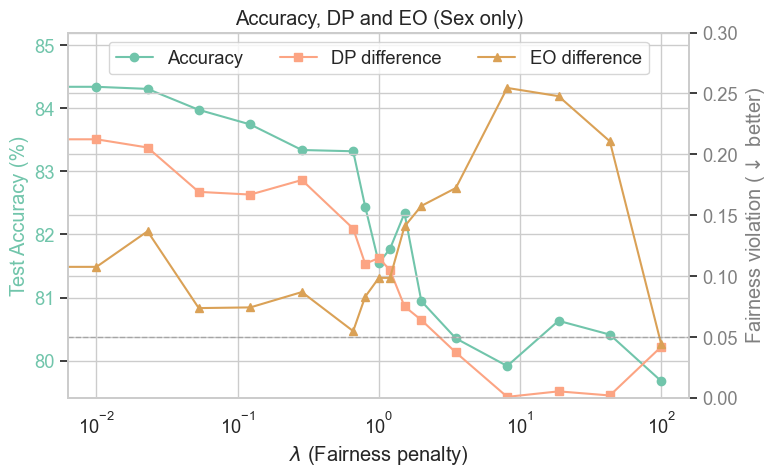

In [14]:
plot_fairness_and_accuracy(results, group="sex", title="Accuracy, DP and EO (Sex only)")

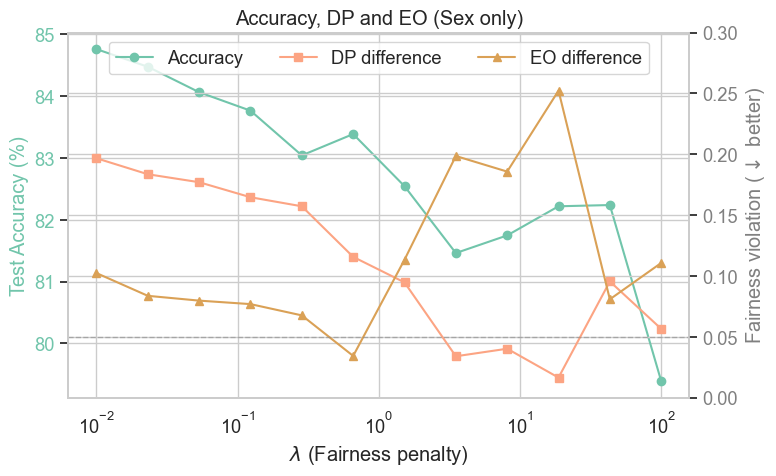

In [47]:
plot_fairness_and_accuracy(results, group="sex", title="Accuracy, DP and EO (Sex only)")

In [15]:
def plot_fairness_illusion(results, title="Fair Outputs, Biased Representations"):
    sns.set(style="whitegrid", font_scale=1.3)

    df = pd.DataFrame({
        "lambda": results["lambda"],
        "dp_diff": results["dp_diff_sex"],
        "probe_l1": results["probe_l1_acc"],  # or l1→l2 if preferred
        "probe_l2": results["probe_l2_acc"],  # or l2→l2
    })

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Red line: DP diff (left y-axis)
    ax1.plot(df["lambda"], df["dp_diff"], color="tab:red", label="DP Difference", marker="o", linewidth=2)
    ax1.set_xscale("log")
    ax1.set_xlabel(r"$\lambda$ (Fairness penalty)")
    ax1.set_ylabel("Demographic Parity Difference", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")
    ax1.axhline(0.05, color="gray", linestyle="--", linewidth=1, label="Fairness Threshold (0.05)")

    # Shade region where DP diff < 0.05
    dp_below = df["dp_diff"] < 0.05
    if any(dp_below):
        lambda_min = df["lambda"][dp_below.idxmax()]
        lambda_max = df["lambda"][dp_below[::-1].idxmax()]
        ax1.axvspan(lambda_min, lambda_max, color="red", alpha=0.1)

    # Blue line: Probe accuracy (right y-axis)
    ax2 = ax1.twinx()
    ax2.plot(df["lambda"], df["probe_l1"], color="tab:blue", label="Probe Accuracy (L1)", marker="s", linestyle="-", linewidth=2)
    ax2.plot(df["lambda"], df["probe_l2"], color="tab:blue", label="Probe Accuracy (L2)", marker="^", linestyle="--", linewidth=2)
    ax2.set_ylabel("Probe Accuracy for Gender Detection", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.axhline(0.95, linestyle=":", color="gray", linewidth=1, alpha=0.6)

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)

    plt.title(title)
    plt.tight_layout()
    plt.show()

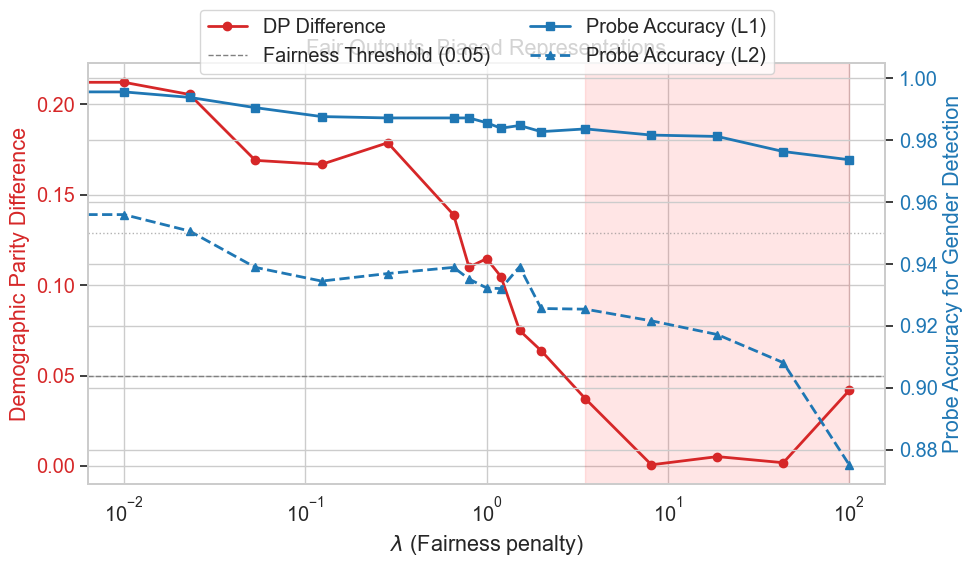

In [16]:
plot_fairness_illusion(results)

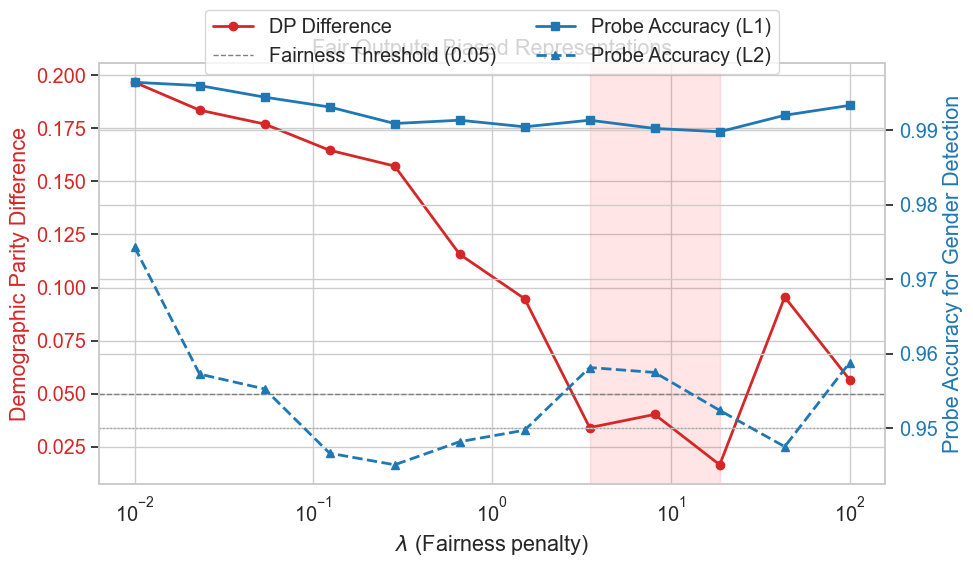

In [51]:
plot_fairness_illusion(results)

In [40]:
from matplotlib.colors import LogNorm

def plot_performance_tradeoffs(results, title="Performance Trade-offs"):
    sns.set(style="whitegrid", font_scale=1.2)

    df = pd.DataFrame({
        "lambda": results["lambda"],
        "accuracy": [100 * a for a in results["test_accuracy"]],
        "dp_diff": results["dp_diff_sex"],
        "eo_diff": results["eo_diff_sex"]
    })

    df = df[df["lambda"] > 0]  # remove zero or negative values
    lambdas = df["lambda"]

    lambdas_pos = lambdas[lambdas > 0]
    norm = LogNorm(vmin=lambdas_pos.min(), vmax=lambdas_pos.max())
    # norm = LogNorm(vmin=min(lambdas), vmax=max(lambdas))
    cmap = plt.cm.viridis

    fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # ----- Panel 1: Accuracy vs DP diff -----
    sc1 = axes[0].scatter(df["dp_diff"], df["accuracy"], c=lambdas.values, cmap=cmap,
                          s=70, norm=norm, edgecolor="black")
    axes[0].axvline(0.05, linestyle="--", color="gray", linewidth=1, label="DP threshold = 0.05")
    axes[0].set_xlabel("Demographic Parity Difference")
    axes[0].set_ylabel("Test Accuracy (%)")
    axes[0].set_title("Accuracy vs Fairness")
    axes[0].legend(loc="upper left")

    # Annotate point closest to DP = 0.05
    dp_target = 0.05
    idx_fair = (df["dp_diff"] - dp_target).abs().idxmin()
    x_fair, y_fair = df.loc[idx_fair, ["dp_diff", "accuracy"]]
    axes[0].annotate("Accuracy drop when pushing fairness",
                     xy=(x_fair, y_fair),
                     xytext=(x_fair + 0.01, y_fair + 1),
                     arrowprops=dict(arrowstyle="->", color="black"),
                     fontsize=10, color="black")

    # ----- Panel 2: DP diff vs EO diff -----
    sc2 = axes[1].scatter(df["dp_diff"], df["eo_diff"], c=lambdas.values, cmap=cmap,
                          norm=norm, s=70, edgecolor="black")
    axes[1].plot([0, 0.25], [0, 0.25], linestyle="--", color="gray", linewidth=1, label="DP = EO")
    axes[1].axvline(0.05, linestyle="--", color="gray", linewidth=1)
    axes[1].set_xlabel("Demographic Parity Difference")
    axes[1].set_ylabel("Equalized Odds Difference")
    axes[1].set_title("Fairness Metrics Trade-off")
    axes[1].legend(loc="upper right")

    # Annotate furthest point from DP=EO diagonal
    dists = ((df["dp_diff"] - df["eo_diff"]) ** 2) ** 0.5
    idx_max_div = dists.idxmax()
    x_div, y_div = df.loc[idx_max_div, ["dp_diff", "eo_diff"]]
    axes[1].annotate("Metrics maximally diverge",
                     xy=(x_div, y_div),
                     xytext=(x_div + 0.04, y_div-0.02 ),
                     arrowprops=dict(arrowstyle="->", color="black"),
                     fontsize=10, color="black")

    # ----- Shared Colorbar -----
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.85, pad=0.02)
    cbar.set_label(r"$\lambda$ (Fairness penalty)")
    cbar.set_ticks([0.01, 0.1, 1, 10, 100])
    cbar.set_ticklabels([r"$10^{-2}$", r"$10^{-1}$", r"$1$", r"$10$", r"$10^2$"])

    fig.suptitle(title)
    plt.show()

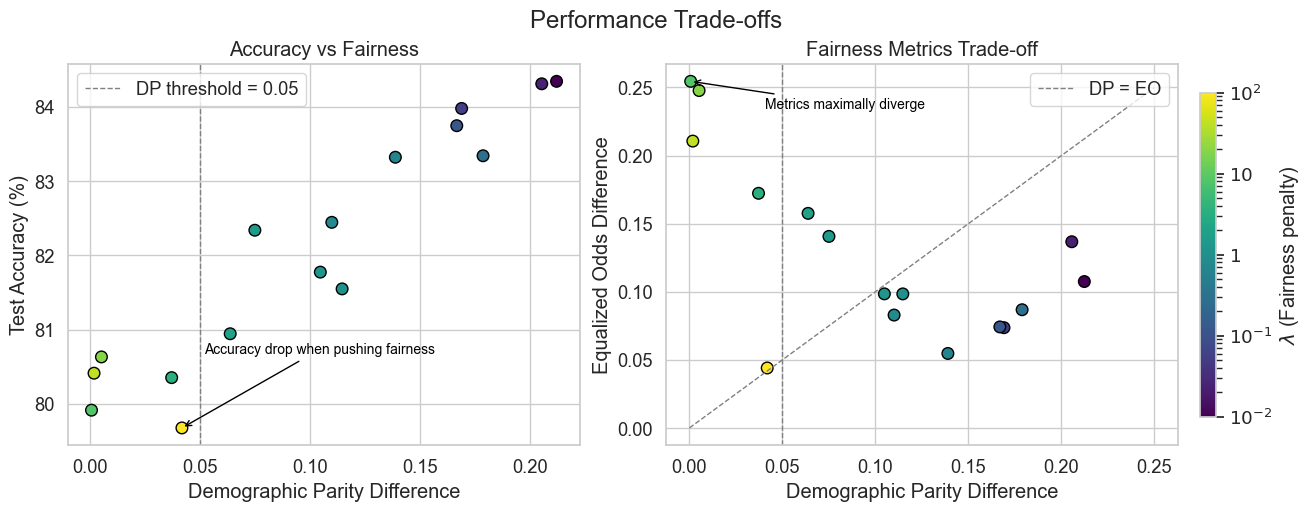

In [41]:
plot_performance_tradeoffs(results)

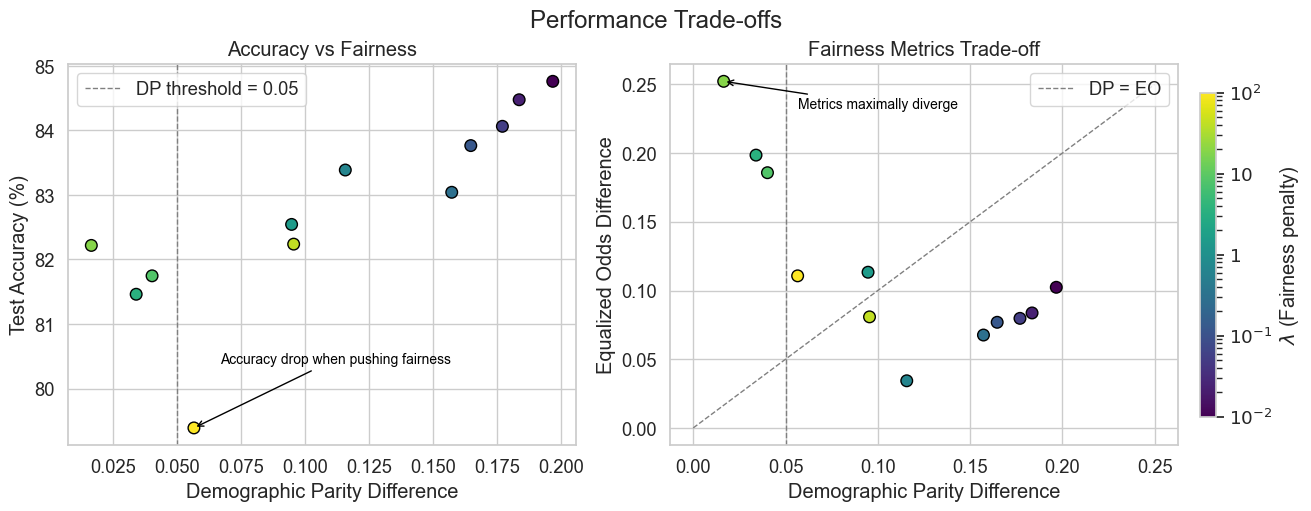

In [104]:
plot_performance_tradeoffs(results)

In [54]:
def plot_cross_layer_transfer_enhanced(results, title="Cross-Layer Probe Transfer Accuracy"):
    lambdas = np.array(results["lambda"])
    acc_l1_to_l2 = np.array(results["probe_l1_to_l2"])
    acc_l2_to_l1 = np.array(results["probe_l2_to_l1"])

    plt.figure(figsize=(8, 5))

    # Plot transfer lines
    plt.plot(lambdas, acc_l1_to_l2, marker='o', linestyle='-', label="L1 → L2", color="tab:blue")
    plt.plot(lambdas, acc_l2_to_l1, marker='s', linestyle='--', label="L2 → L1", color="tab:green")

    # Chance line
    plt.axhline(0.5, linestyle=":", color="gray", linewidth=1.2, label="Chance level (50%)")

    

    # Log scale and limits
    plt.xscale("log")
    plt.ylim(0.3, 0.7)
    plt.xlabel(r"$\lambda$ (Fairness penalty)")
    plt.ylabel("Probe Transfer Accuracy")
    plt.title(title)

    # Shaded band from λ=2 to 20
    plt.axvspan(0.5, 20, color='orange', alpha=0.15)
    plt.text(3.5, 0.68, "Maximum\nrepresentation\ntransformation",
         color="orange", fontsize=10, va="top", ha="center")

    # Legend, grid
    plt.legend(loc="upper left")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

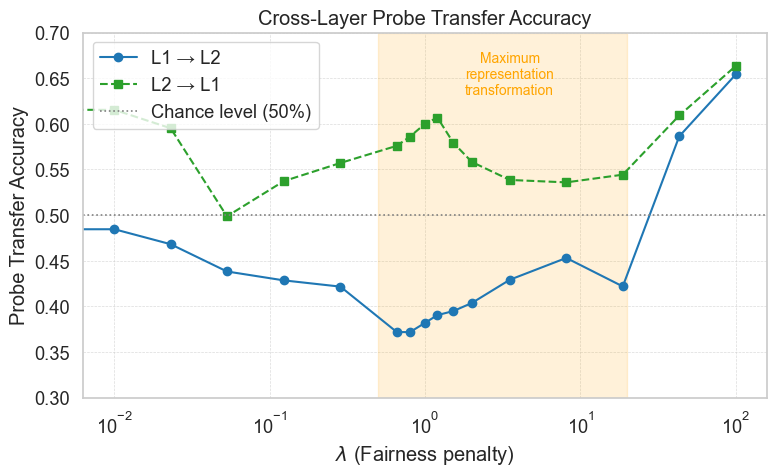

In [55]:
plot_cross_layer_transfer_enhanced(results)

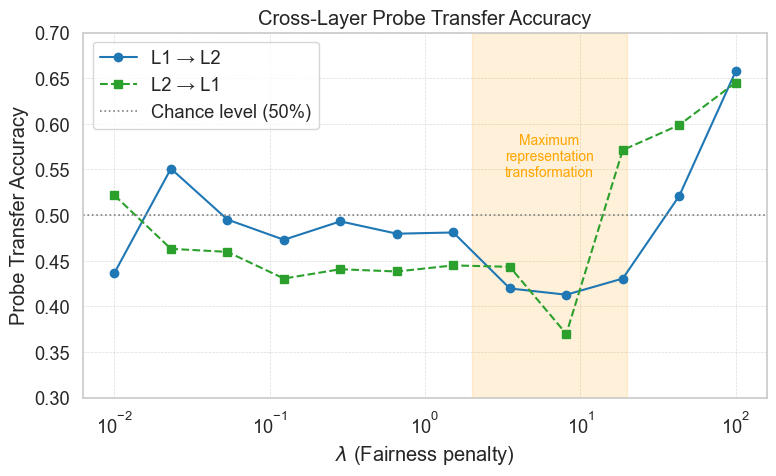

In [153]:
plot_cross_layer_transfer_enhanced(results)

## Penalizing the loss in regard to the sex and gender

In [56]:
model = FairMLP(input_dim=train_oh.shape[1] - 1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
bce_loss = nn.BCELoss()

lambda_logspace = [round(l, 3) for l in np.logspace(-2, 2, 12).tolist()]
lambda_manual = [0.0, 0.8, 1.0, 1.2, 2.0]

lambda_values = sorted(set(lambda_logspace + lambda_manual))

results_both = {
    "lambda": [],
    "test_accuracy": [],
    "dp_diff_sex": [],
    "dp_ratio_sex": [],
    "eo_diff_sex": [],
    "eo_ratio_sex": [],
    "dp_diff_race": [],
    "dp_ratio_race": [],
    "eo_diff_race": [],
    "eo_ratio_race": [],
    "hidden_1": [],
    "hidden_2": [],
    "output": [],
}



for lambda_dp in lambda_values:
    print(f"\nTraining (DP penalty on SEX + RACE), λ = {lambda_dp}")
    

    # Training loop
    for epoch in range(10):
        model.train()
        for x, y, s, s2 in train_loader:  # ignore s2
            optimizer.zero_grad()
            y_hat = model(x)
            loss_base = bce_loss(y_hat, y)
            loss_dp_sex = demographic_parity_loss(y_hat, s)
            loss_dp_race = demographic_parity_loss(y_hat, s2)
            loss = loss_base + lambda_dp * (loss_dp_sex + loss_dp_race)
            loss.backward()
            optimizer.step()
            

    # Evaluation
    model.eval()
    X_test = torch.tensor(test_oh.drop(columns=["salary"]).values, dtype=torch.float32)
    y_test = test_oh["salary"].values
    s_sex = test_oh["sex"].values

    race_columns = [col for col in test_oh.columns if col.startswith("race_")]
    race_one_hot = test_oh[race_columns].values
    s_race = np.argmax(race_one_hot, axis=1)

    with torch.no_grad():
        h1, h2 = model.get_hidden(X_test)
        h3 = model(X_test).unsqueeze(1)

    test_pred = (h3.numpy() > 0.5).astype(int)

    # === PROBING FOR GENDER (SEX) ===
    train_idx, val_idx = train_test_split(np.arange(len(s_sex)), test_size=0.3, stratify=s_sex, random_state=42)
    h1_train, h1_val = h1[train_idx], h1[val_idx]
    h2_train, h2_val = h2[train_idx], h2[val_idx]
    y_train, y_val = s_sex[train_idx], s_sex[val_idx]

    probe_l1 = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, class_weight='balanced').fit(h1_train, y_train)
    probe_l2 = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, class_weight='balanced').fit(h2_train, y_train)
    
    probe_l1_acc = accuracy_score(y_val, probe_l1.predict(h1_val))  # L1 probe tested on L1
    probe_l2_acc = accuracy_score(y_val, probe_l2.predict(h2_val))  # L2 probe tested on L2

    l1_to_l2 = accuracy_score(y_val, probe_l1.predict(h2_val))
    l2_to_l1 = accuracy_score(y_val, probe_l2.predict(h1_val))

    results_both.setdefault("probe_l1_to_l2", []).append(l1_to_l2)
    results_both.setdefault("probe_l2_to_l1", []).append(l2_to_l1)
    results_both.setdefault("probe_l1_acc", []).append(probe_l1_acc)
    results_both.setdefault("probe_l2_acc", []).append(probe_l2_acc)

    # === PROBING FOR RACE ===
    train_idx_race, val_idx_race = train_test_split(np.arange(len(s_race)), test_size=0.3, stratify=s_race, random_state=42)
    h1_train_r, h1_val_r = h1[train_idx_race], h1[val_idx_race]
    h2_train_r, h2_val_r = h2[train_idx_race], h2[val_idx_race]
    y_train_r, y_val_r = s_race[train_idx_race], s_race[val_idx_race]

    probe_r1 = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, class_weight='balanced',
                                  solver='lbfgs').fit(h1_train_r, y_train_r)
    probe_r2 = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, class_weight='balanced',
                                  solver='lbfgs').fit(h2_train_r, y_train_r)

    probe_r1_acc = accuracy_score(y_val_r, probe_r1.predict(h1_val_r))  # L1 probe for race
    probe_r2_acc = accuracy_score(y_val_r, probe_r2.predict(h2_val_r))  # L2 probe for race

    r1_to_r2 = accuracy_score(y_val_r, probe_r1.predict(h2_val_r))      # L1 probe on L2 hidden
    r2_to_r1 = accuracy_score(y_val_r, probe_r2.predict(h1_val_r))      # L2 probe on L1 hidden

    results_both.setdefault("race_probe_l1_to_l2", []).append(r1_to_r2)
    results_both.setdefault("race_probe_l2_to_l1", []).append(r2_to_r1)
    results_both.setdefault("race_probe_l1_acc", []).append(probe_r1_acc)
    results_both.setdefault("race_probe_l2_acc", []).append(probe_r2_acc)

    # === INTERSECTIONAL PROBING ===
    # Detect gender within each race group
    race_values = np.unique(s_race)
    for r in race_values:
        idx_r = np.where(s_race == r)[0]
        if len(np.unique(s_sex[idx_r])) < 2:
            continue  # skip if not enough variation
        probe_sex_r = LogisticRegression(max_iter=1000, class_weight='balanced').fit(h1[idx_r], s_sex[idx_r])
        acc = accuracy_score(s_sex[idx_r], probe_sex_r.predict(h1[idx_r]))
        results_both.setdefault(f"probe_sex_within_race_{r}", []).append(acc)

    # Detect race within each gender group
    for g in [0, 1]:
        idx_g = np.where(s_sex == g)[0]
        if len(np.unique(s_race[idx_g])) < 2:
            continue
        probe_race_g = LogisticRegression(max_iter=1000, class_weight='balanced').fit(h1[idx_g], s_race[idx_g])
        acc = accuracy_score(s_race[idx_g], probe_race_g.predict(h1[idx_g]))
        results_both.setdefault(f"probe_race_within_gender_{g}", []).append(acc)

    # Fairness metrics
    dpd_sex = demographic_parity_difference(y_test, test_pred, sensitive_features=s_sex)
    dpr_sex = demographic_parity_ratio(y_test, test_pred, sensitive_features=s_sex)
    eod_sex = equalized_odds_difference(y_test, test_pred, sensitive_features=s_sex)
    eor_sex = equalized_odds_ratio(y_test, test_pred, sensitive_features=s_sex)

    # Fairness metrics — RACE
    dpd_race = demographic_parity_difference(y_test, test_pred, sensitive_features=s_race)
    dpr_race = demographic_parity_ratio(y_test, test_pred, sensitive_features=s_race)
    eod_race = equalized_odds_difference(y_test, test_pred, sensitive_features=s_race)
    eor_race = equalized_odds_ratio(y_test, test_pred, sensitive_features=s_race)


    results_both["lambda"].append(lambda_dp)
    results_both["test_accuracy"].append(accuracy_score(y_test, test_pred))
    results_both["dp_diff_sex"].append(dpd_sex)
    results_both["dp_ratio_sex"].append(dpr_sex)
    results_both["eo_diff_sex"].append(eod_sex)
    results_both["eo_ratio_sex"].append(eor_sex)
    results_both["dp_diff_race"].append(dpd_race)
    results_both["dp_ratio_race"].append(dpr_race)
    results_both["eo_diff_race"].append(eod_race)
    results_both["eo_ratio_race"].append(eor_race)
    results_both["hidden_1"].append(h1.numpy())
    results_both["hidden_2"].append(h2.numpy())
    results_both["output"].append(h3.numpy())


Training (DP penalty on SEX + RACE), λ = 0.0

Training (DP penalty on SEX + RACE), λ = 0.01

Training (DP penalty on SEX + RACE), λ = 0.023

Training (DP penalty on SEX + RACE), λ = 0.053

Training (DP penalty on SEX + RACE), λ = 0.123

Training (DP penalty on SEX + RACE), λ = 0.285

Training (DP penalty on SEX + RACE), λ = 0.658

Training (DP penalty on SEX + RACE), λ = 0.8

Training (DP penalty on SEX + RACE), λ = 1.0

Training (DP penalty on SEX + RACE), λ = 1.2

Training (DP penalty on SEX + RACE), λ = 1.52

Training (DP penalty on SEX + RACE), λ = 2.0

Training (DP penalty on SEX + RACE), λ = 3.511

Training (DP penalty on SEX + RACE), λ = 8.111

Training (DP penalty on SEX + RACE), λ = 18.738

Training (DP penalty on SEX + RACE), λ = 43.288

Training (DP penalty on SEX + RACE), λ = 100.0


In [57]:

def plot_dual_axis_fairness(results, title="Accuracy and Fairness vs λ (Sex & Race)"):
    sns.set(style="whitegrid", font_scale=1.2)

    # Create dataframe
    df = pd.DataFrame({
        "lambda": results["lambda"],
        "accuracy": [100 * a for a in results["test_accuracy"]],
        "dp_diff_sex": results["dp_diff_sex"],
        "eo_diff_sex": results["eo_diff_sex"],
        "dp_diff_race": results["dp_diff_race"],
        "eo_diff_race": results["eo_diff_race"],
    })

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot accuracy on left axis
    sns.lineplot(data=df, x="lambda", y="accuracy", marker="o", color="tab:blue", ax=ax1, label="Accuracy")
    ax1.set_xlabel(r"$\lambda$ (Fairness penalty)")
    ax1.set_ylabel("Test Accuracy (%)", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.set_xscale("log")

    # Plot fairness on right axis
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x="lambda", y="dp_diff_sex", marker="s", linestyle="--", color="tab:red", ax=ax2, label="DP diff (sex)")
    sns.lineplot(data=df, x="lambda", y="eo_diff_sex", marker="^", linestyle=":", color="tab:green", ax=ax2, label="EO diff (sex)")
    sns.lineplot(data=df, x="lambda", y="dp_diff_race", marker="s", linestyle="--", color="tab:orange", ax=ax2, label="DP diff (race)")
    sns.lineplot(data=df, x="lambda", y="eo_diff_race", marker="^", linestyle=":", color="tab:purple", ax=ax2, label="EO diff (race)")

    ax2.set_ylabel("Fairness Metrics (↓ better)", color="gray")
    ax2.tick_params(axis="y", labelcolor="gray")
    ax2.axhline(0.05, linestyle="--", color="gray", linewidth=1, alpha=0.5)

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)

    plt.title(title)
    plt.tight_layout()
    plt.show()

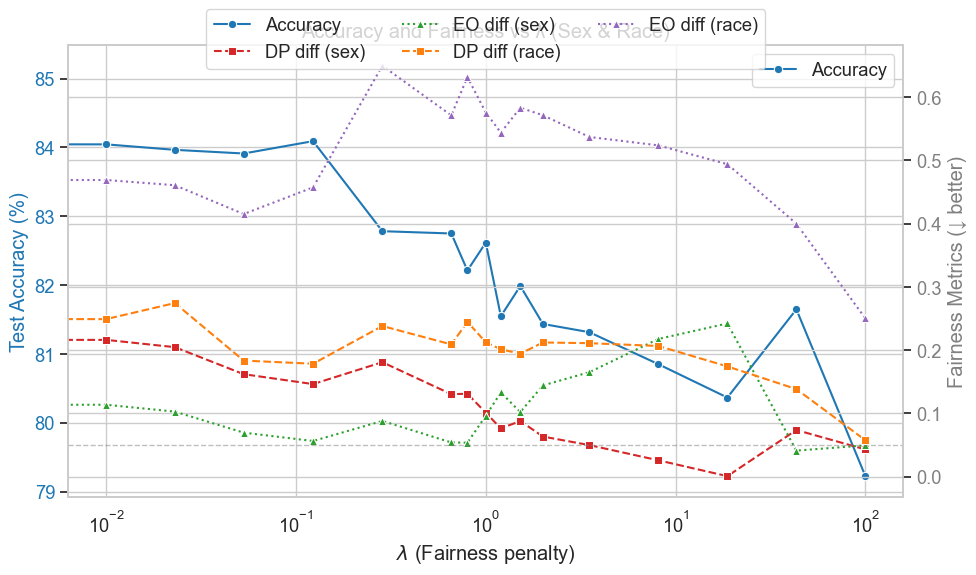

In [58]:
plot_dual_axis_fairness(results_both)

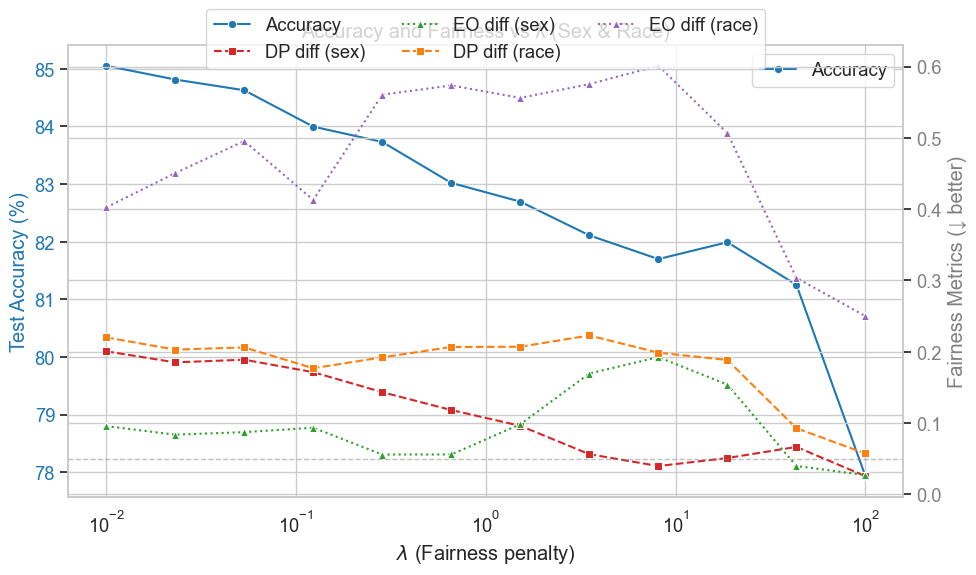

In [156]:
plot_dual_axis_fairness(results_both)

In [59]:
def plot_bias_displacement(results, results_both):
    lambdas = results["lambda"]  # same λ values assumed for both
    probe_l1_acc_sex_only = results["probe_l2_acc"]
    probe_l1_acc_sex_race = results_both["probe_l2_acc"]

    sns.set(style="whitegrid", font_scale=1.3)
    plt.figure(figsize=(8, 5))

    plt.plot(lambdas, probe_l1_acc_sex_only, label="Sex-only constraint", 
             marker="o", linestyle="-", color="tab:blue")
    plt.plot(lambdas, probe_l1_acc_sex_race, label="Sex + Race constraint", 
             marker="s", linestyle="--", color="tab:orange")

    plt.xscale("log")
    plt.ylim(0.8, 1.01)
    plt.axhline(0.5, color="gray", linestyle=":", linewidth=1)

    plt.xlabel(r"$\lambda$ (Fairness Penalty)", fontsize=12)
    plt.ylabel("Gender Probe Accuracy (Layer 1)", fontsize=12)
    plt.title("Bias Displacement Under Multi-Attribute Constraints", fontsize=14)
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

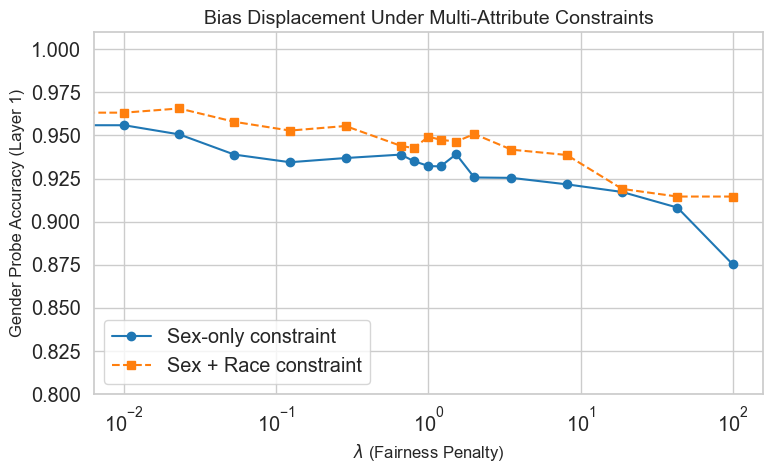

In [60]:
plot_bias_displacement(results, results_both)

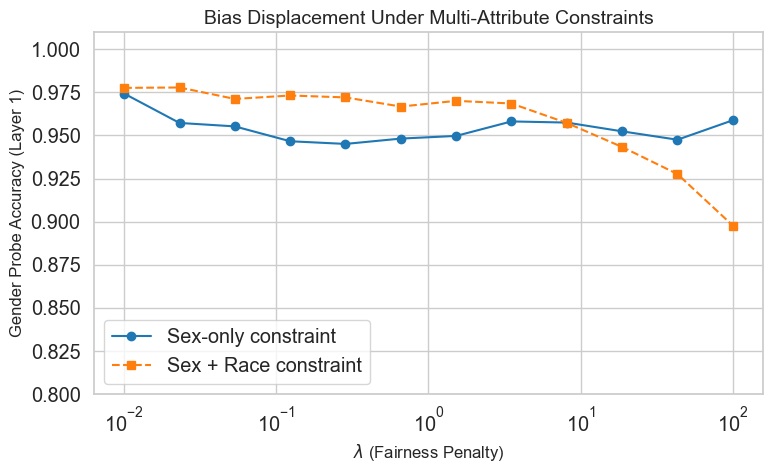

In [165]:
plot_bias_displacement(results, results_both)

## Final stats

In [64]:
def summarize_at_lambda(results_sex, results_both, lambda_target=0.5):
    # Find nearest index to lambda_target
    idx_sex = np.argmin(np.abs(np.array(results_sex["lambda"]) - lambda_target))
    idx_both = np.argmin(np.abs(np.array(results_both["lambda"]) - lambda_target))

    table = pd.DataFrame({
        "Model": ["Sex-only", "Sex+Race"],
        "λ": [results_sex["lambda"][idx_sex], results_both["lambda"][idx_both]],
        "DP diff (sex)": [results_sex["dp_diff_sex"][idx_sex], results_both["dp_diff_sex"][idx_both]],
        "DP diff (race)": ["—", results_both["dp_diff_race"][idx_both]],
        "Gender probe L1": [results_sex["probe_l1_acc"][idx_sex], results_both["probe_l1_acc"][idx_both]],
        "Gender probe L2": [results_sex["probe_l2_acc"][idx_sex], results_both["probe_l2_acc"][idx_both]],
        "Race probe L1": ["—", results_both["race_probe_l1_acc"][idx_both]],
        "Race probe L2": ["—", results_both["race_probe_l2_acc"][idx_both]],
        "Test Accuracy": [results_sex["test_accuracy"][idx_sex], results_both["test_accuracy"][idx_both]]
    })

    return table.round(3)

In [65]:
table_1 = summarize_at_lambda(results, results_both, lambda_target=0.5)
table_2= summarize_at_lambda(results, results_both, lambda_target=1.5)

In [66]:
table_1

,Model,λ,DP diff (sex),DP diff (race),Gender probe L1,Gender probe L2,Race probe L1,Race probe L2,Test Accuracy
0,Sex-only,0.658,0.139,—,0.987,0.939,—,—,0.833
1,Sex+Race,0.658,0.130,0.20894,0.986,0.944,0.999779,0.97521,0.827


In [67]:
table_2

,Model,λ,DP diff (sex),DP diff (race),Gender probe L1,Gender probe L2,Race probe L1,Race probe L2,Test Accuracy
0,Sex-only,1.52,0.075,—,0.985,0.939,—,—,0.823
1,Sex+Race,1.52,0.088,0.194364,0.986,0.946,0.999336,0.985834,0.820


## Validating Null probe

In [68]:
np.random.seed(42)  # for reproducibility
random_labels = np.random.randint(0, 2, size=len(h1))  # shape: (N,)
train_idx, val_idx = train_test_split(
    np.arange(len(random_labels)), test_size=0.3, stratify=random_labels, random_state=42
)

h1_train, h1_val = h1[train_idx], h1[val_idx]
h2_train, h2_val = h2[train_idx], h2[val_idx]
y_train, y_val = random_labels[train_idx], random_labels[val_idx]
def train_and_eval_probe(h_train, h_val, y_train, y_val):
    probe = LogisticRegression(
        penalty='l2', C=1.0, max_iter=1000, class_weight='balanced'
    )
    probe.fit(h_train, y_train)
    acc = accuracy_score(y_val, probe.predict(h_val))
    return acc

acc_null_h1 = train_and_eval_probe(h1_train, h1_val, y_train, y_val)
acc_null_h2 = train_and_eval_probe(h2_train, h2_val, y_train, y_val)

print(f"Null probe accuracy on layer 1: {acc_null_h1:.3f}")
print(f"Null probe accuracy on layer 2: {acc_null_h2:.3f}")

Null probe accuracy on layer 1: 0.502
Null probe accuracy on layer 2: 0.501


## Layer Visualizations

In [69]:
def plot_tsne_umap_by_gender(results, lambda_val, method="tsne"):
    # Find the index of the lambda value
    gender = test_oh["sex"].values 

    if lambda_val not in results["lambda"]:
        raise ValueError(f"λ = {lambda_val} not found in results")

    idx = results["lambda"].index(lambda_val)
    
    h1 = results["hidden_1"][idx]
    h2 = results["hidden_2"][idx]
    

    # Dimensionality reduction
    def reduce_dim(X, method):
        if method == "tsne":
            reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        elif method == "umap":
            reducer = umap.UMAP(n_components=2, random_state=42)
        else:
            raise ValueError("Method must be 'tsne' or 'umap'")
        return reducer.fit_transform(X)

    proj_h1 = reduce_dim(h1, method)
    proj_h2 = reduce_dim(h2, method)

    # Build dataframe
    def make_df(emb, gender, layer_name):
        return pd.DataFrame({
            "x": emb[:, 0],
            "y": emb[:, 1],
            "gender": ["Male" if g == 1 else "Female" for g in gender],
            "layer": layer_name
        })

    df_h1 = make_df(proj_h1, gender, "Layer 1")
    df_h2 = make_df(proj_h2, gender, "Layer 2")
    df_all = pd.concat([df_h1, df_h2], ignore_index=True)

    # Plot
    sns.set(style="white", font_scale=1.2)
    g = sns.FacetGrid(df_all, col="layer", hue="gender", height=5, aspect=1)
    g.map_dataframe(sns.scatterplot, x="x", y="y", alpha=0.7)
    g.add_legend()
    g.set_titles(col_template="{col_name}")
    plt.suptitle(f"{method.upper()} Projection of Hidden Representations by Gender\n(λ = {lambda_val})", y=1.05)
    plt.tight_layout()
    plt.show()

Lambdas to choose from: 

In [70]:
results['lambda']

[0.0,
 0.01,
 0.023,
 0.053,
 0.123,
 0.285,
 0.658,
 0.8,
 1.0,
 1.2,
 1.52,
 2.0,
 3.511,
 8.111,
 18.738,
 43.288,
 100.0]

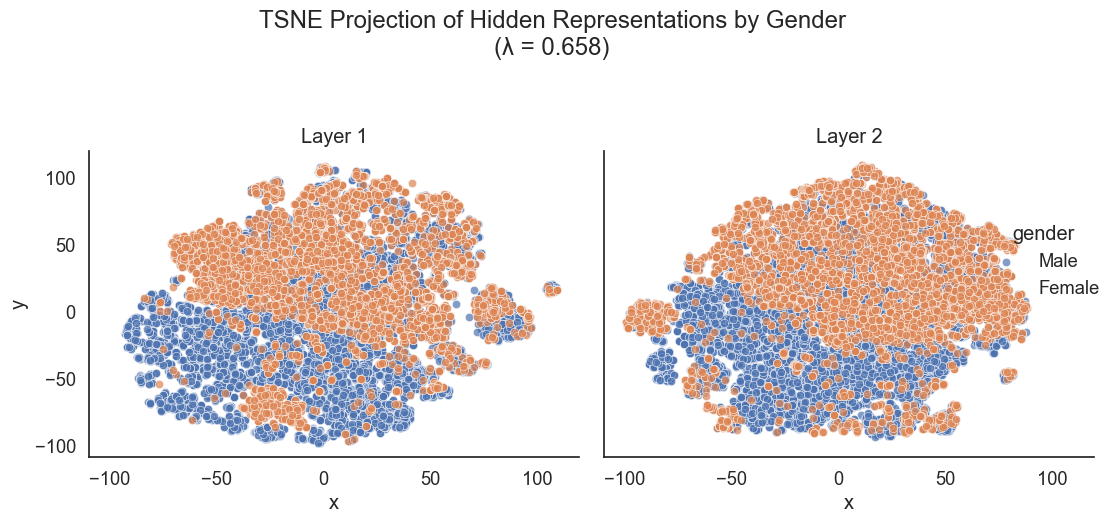

In [71]:
plot_tsne_umap_by_gender(results, lambda_val=0.658, method="tsne")

/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


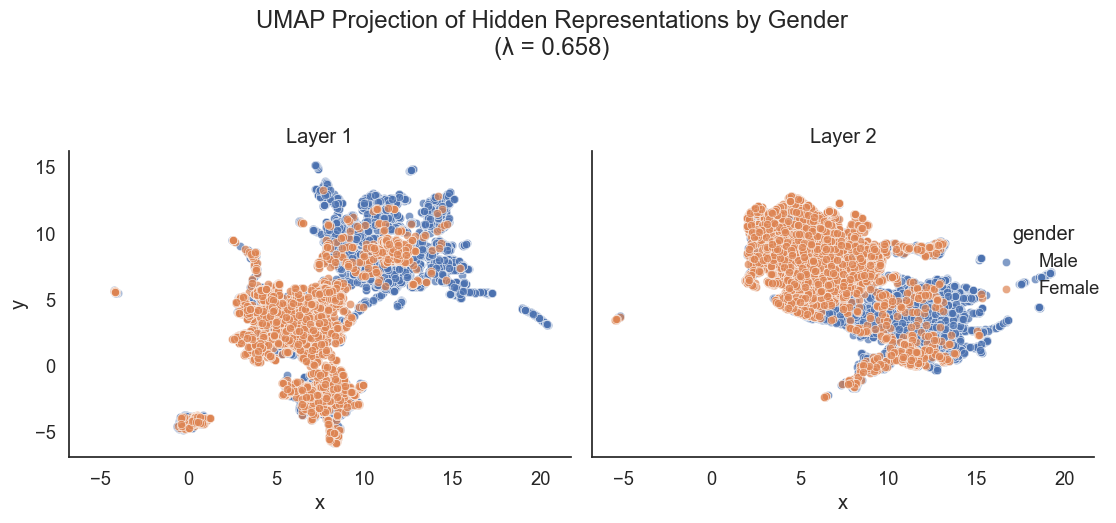

In [72]:
plot_tsne_umap_by_gender(results, lambda_val=0.658, method="umap")

In [73]:
results['lambda']

[0.0,
 0.01,
 0.023,
 0.053,
 0.123,
 0.285,
 0.658,
 0.8,
 1.0,
 1.2,
 1.52,
 2.0,
 3.511,
 8.111,
 18.738,
 43.288,
 100.0]

In [ ]:
def plot_tsne_umap_by_gender(results, lambda_val, method="tsne"):
    # Find the index of the lambda value
   




    # Plot
    sns.set(style="white", font_scale=1.2)
    g = sns.FacetGrid(df_all, col="layer", hue="gender", height=5, aspect=1)
    g.map_dataframe(sns.scatterplot, x="x", y="y", alpha=0.7)
    g.add_legend()
    g.set_titles(col_template="{col_name}")
    plt.suptitle(f"{method.upper()} Projection of Hidden Representations by Gender\n(λ = {lambda_val})", y=1.05)
    plt.tight_layout()
    plt.show()

/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/clarakumpel/anaconda3/envs/c

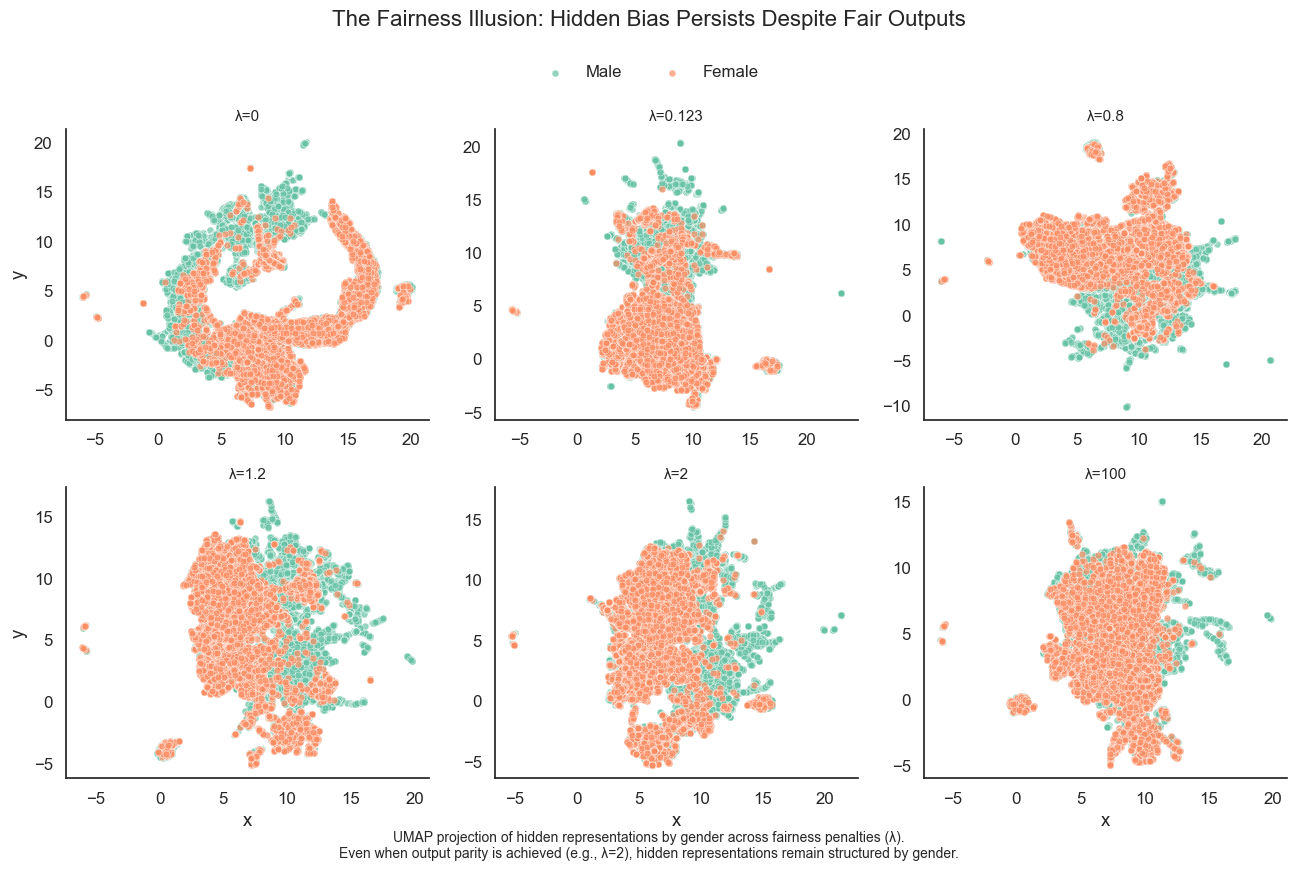

In [76]:
method = 'umap'
gender = test_oh["sex"].values 
sns.set(style="white", font_scale=1.1)
sensitive_attr = test_oh["sex"].values  # or "race"
X_test = torch.tensor(test_oh.drop(columns=["salary"]).values, dtype=torch.float32)
y_test = test_oh["salary"].values

def reduce_dim(X, method):
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    elif method == "umap":
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'tsne' or 'umap'")
    return reducer.fit_transform(X)

def make_df(emb, gender, layer_name, lambda_val):
    lambda_label = f"λ={lambda_val:.3g}"
    return pd.DataFrame({
        "x": emb[:, 0],
        "y": emb[:, 1],
        "gender": ["Male" if g == 1 else "Female" for g in gender],
        "layer": layer_name,
        "lambda_label": lambda_label
    })

# Collect UMAP projections
umap_results = []

# [0.0, 0.123, 0.8, 1.2, 2.0, 100.0]

for lmbda in [0.0, 0.123, 0.8, 1.2, 2.0, 100.0]:
    idx = results["lambda"].index(lmbda)
    h1 = results["hidden_1"][idx]
    h2 = results["hidden_2"][idx]

    proj_h1 = reduce_dim(h1, method)
    proj_h2 = reduce_dim(h2, method)

    df_h1 = make_df(proj_h1, gender, "Layer 1", lmbda)
    df_h2 = make_df(proj_h2, gender, "Layer 2", lmbda)
    df_all = pd.concat([df_h1, df_h2], ignore_index=True)

    umap_results.append(df_all)
    



df_all = pd.concat(umap_results, ignore_index=True)
highlight_lambda = "λ=2.0"


# Plot
g = sns.FacetGrid(df_all, col="lambda_label", hue="gender", height=4, col_wrap=3, palette="Set2", sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="x", y="y", alpha=0.7, s=25)
g.add_legend(title="Gender")

# Custom titles
for ax, label in zip(g.axes.flat, g.col_names):
    if label == highlight_lambda:
        ax.set_title(f"{label} (Fairness-Constrained)", fontsize=11)
        # Add bounding box
        ax.add_patch(Rectangle(
            (ax.get_xlim()[0], ax.get_ylim()[0]),
            ax.get_xlim()[1] - ax.get_xlim()[0],
            ax.get_ylim()[1] - ax.get_ylim()[0],
            linewidth=2, edgecolor='black', facecolor='none'
        ))
    else:
        ax.set_title(label, fontsize=11)


# Adjust legend
sns.move_legend(
    g, "upper center",
    bbox_to_anchor=(0.5, 1.0),
    ncol=2, title=None, frameon=False
)

# Annotate figure
plt.suptitle("The Fairness Illusion: Hidden Bias Persists Despite Fair Outputs", fontsize=16, y=1.05)
plt.figtext(0.5, -0.01,
    "UMAP projection of hidden representations by gender across fairness penalties (λ).\n"
    "Even when output parity is achieved (e.g., λ=2), hidden representations remain structured by gender.",
    ha="center", fontsize=10)

plt.tight_layout()
plt.show()

old code:

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

df_all = pd.concat(umap_results, ignore_index=True)

import seaborn as sns
sns.set(style="white", font_scale=1.1)

gender_labels = ["Male" if g == 1 else "Female" for g in sensitive_attr]
highlight_lambda = "λ=2.0"  # or whatever is your main result


g = sns.FacetGrid(df_all, col="lambda", hue="gender", height=4, col_wrap=3, palette="Set2", sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="x", y="y", alpha=0.7, s=25)
g.add_legend(title="Gender")


title_map = {
    f"λ={l}": f"λ={l}" if l != 2.0 else "λ=2.0 (Fairness-Constrained)"
    for l in lambda_list
}
for ax, label in zip(g.axes.flat, g.col_names):
    ax.set_title(title_map[label], fontsize=11)

# Add bounding box highlight around λ=2.0
for ax, title in zip(g.axes.flat, g.col_names):
    if title == highlight_lambda:
        # Highlight box
        ax.add_patch(Rectangle(
            (ax.get_xlim()[0], ax.get_ylim()[0]),
            ax.get_xlim()[1] - ax.get_xlim()[0],
            ax.get_ylim()[1] - ax.get_ylim()[0],
            linewidth=2, edgecolor='black', facecolor='none'
        ))

# After g.map_dataframe(...)
# Update titles cleanly all at once:
new_titles = [t if t != highlight_lambda else f"{highlight_lambda} (Fairness-Constrained)"
              for t in g.col_names]
for ax, new_title in zip(g.axes.flat, new_titles):
    ax.set_title(new_title)

sns.move_legend(
    g, "upper center",
    bbox_to_anchor=(0.5, 1.0),  # push it between figure and title
    ncol=2, title=None, frameon=False
)


# Annotate figure title
plt.suptitle("The Fairness Illusion: Hidden Bias Persists Despite Fair Outputs", fontsize=16, y=1.05)

# Optionally: add caption/annotation outside of plots
plt.figtext(0.5, -0.01,
    "UMAP projection of hidden representations by gender across fairness penalties (λ).\n"
    "Even when output parity is achieved (e.g., λ=2.0), hidden representations remain structured by gender.",
    ha="center", fontsize=10)



plt.tight_layout()
plt.show()